In [1]:
import os
os.chdir(os.path.expanduser("~/ppi-core-genes/"))
from speos.utils.datahandlers import ResultsHandler
from speos.postprocessing.postprocessor import PostProcessor
from speos.utils.config import Config
from speos.visualization.settings import *

import numpy as np
import matplotlib as plt

# Get the Data first and adjust pvals jointly

In [2]:
import os
os.chdir("/home/icb/florin.ratajczak/ppi-core-genes")

from speos.utils.config import Config
from speos.postprocessing.postprocessor import PostProcessor
import json
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection as fdr

def colorFader(c1="#000000", c2="#ffffff", mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    import matplotlib as mpl
    import numpy as np
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

convergence_score = 1

diseases = ["cardiovascular", "immune_dysregulation", "bm_disorder", "diabetes", "insulin_disorder"]
pretty_diseases = ["Cardiovascular Disease", "Immune Dysregulation", "Body Mass Disorders", "Diabetes", "Insulin Disorders"]
methods = ["film", "tag", "gcn", "n2vmlp", "mlp"]
pretty_methods = ["FiLM", "TAG", "GCN", "N2V\n+MLP", "MLP"]

disease_ors = {disease: None for disease in pretty_diseases}
disease_pvals = {disease: None for disease in pretty_diseases}
disease_n_dge = {disease: None for disease in pretty_diseases}

outer_dfs_list = []
for disease, pretty_disease in zip(diseases, pretty_diseases):
    all_results = []
    for method, pretty_method in zip(methods, pretty_methods):
        if disease == "immune_dysregulation" and method == "film":
            method = "film_forreal"
            
        if method in ["gcn", "mlp", "n2vmlp"] and disease == "immune_dysregulation":
            method += "_new"

        config = Config()
        config.parse_yaml("/home/icb/florin.ratajczak/ppi-core-genes/configs/config_{}_{}.yaml".format(disease, method))
        
        pp = PostProcessor(config)

        outer_results = "/lustre/groups/epigenereg01/projects/ppi-florin/results/{}_{}outer_results.json".format(disease, method)
        results_file = "/lustre/groups/epigenereg01/projects/ppi-florin/results/{}_{}_outer_0_fold_1.tsv".format(disease, method)

        with open(outer_results, "r") as file:
            outer_results = json.load(file)

        pp.outer_result = outer_results
        pp.init_pp_table()
        results = pp.dge(results_file, convergence_score = convergence_score)
        results = results.drop("Union", axis=0)
       
        if disease_ors[pretty_disease] is None:
            disease_ors[pretty_disease] = pd.DataFrame(data=results["Mendelian ORs"].values, index=results.index, columns=["Mendelian"])
            disease_pvals[pretty_disease] = pd.DataFrame(data=results["Mendelian pvals"].values, index=results.index, columns=["Mendelian"])
        disease_ors[pretty_disease][pretty_method] = results["Candidate ORs"].values
        disease_pvals[pretty_disease][pretty_method] = np.zeros_like(results["Candidate pvals"].values)
        disease_n_dge[pretty_disease] = results["N DEG"].values

        #results["Method"] = ["".join(pretty_method.split("\n"))] * len(results)
        #cols = list(results.columns.values)
        #new_cols = [cols[-1]] + cols[:-1]
        #results = results[new_cols]

        #results.loc["Mendelian adjusted pvals (FDR)"] = pd.Series(fdr(results["Mendelian pvals"].values)[1])
        all_results.append(results)
    
    all_results = pd.concat(all_results, keys=["".join(method.split("\n")) for method in pretty_methods])
    #print(dfs.head())
    #dfs.reset_index(inplace=True)
    for column in all_results.columns:
        if "OR" in column:
            all_results[column] = all_results[column].round(3)

    outer_dfs_list.append(all_results)
    #all_results.loc["Candidate adjusted pvals (FDR)"] = pd.Series(fdr(all_results["Candidate pvals"].values)[1])
    #all_results.to_csv("statistical_dump/{}_ors_dge_cs{}.tsv".format(disease,convergence_score), sep="\t")

    #disease_ors[pretty_disease].transpose().to_csv("results/{}_ors_{}.tsv".format(disease,convergence_score), sep="\t")
    #disease_pvals[pretty_disease].transpose().to_csv("results/{}_pvals{}.tsv".format(disease, convergence_score), sep="\t")

pvals = []
n_candidate = 0
lengths = []
for df in outer_dfs_list:
    new_pvals = df["Candidate pvals"].tolist()
    pvals.extend(new_pvals)
    n_candidate += len(new_pvals)
    lengths.append(len(new_pvals))

print(lengths)

n_mendelian = 0
for df in outer_dfs_list:
    new_pvals = df["Mendelian pvals"].tolist()
    pvals.extend(new_pvals)
    n_mendelian += len(new_pvals)
    
adj_pvals = fdr(pvals)[1]
candidate_pvals = adj_pvals[:n_candidate]
mendelian_pvals = adj_pvals[n_candidate:]
assert len(mendelian_pvals) == n_mendelian
previous_length = 0
for i, (df, disease) in enumerate(zip(outer_dfs_list, pretty_diseases)):
    if i > 0:
        candidates = candidate_pvals[previous_length:lengths[i]+previous_length]
        mendelians = mendelian_pvals[previous_length:lengths[i]+previous_length]
    else:
        candidates = candidate_pvals[:lengths[i]]
        mendelians = mendelian_pvals[:lengths[i]]
    previous_length += lengths[i]

    print((candidates < 0.05).sum())
    df["Candidate adjusted pvals (FDR)"] = candidates
    print((df["Candidate adjusted pvals (FDR)"] < 0.05).sum())
    df["Mendelian adjusted pvals (FDR)"] = mendelians
    columns = df.columns
    df = df[columns[4:-2].tolist() + columns[:4].tolist() + columns[-2:].tolist()]
    df.to_csv("statistical_dump/{}_ors_dge_cs{}.tsv".format(disease, convergence_score), sep="\t")

for df, pretty_disease in zip(outer_dfs_list, pretty_diseases):
    for pretty_method in pretty_methods:
        subset_df = df.loc["".join(pretty_method.split("\n"))]
        disease_pvals[pretty_disease]["Mendelian"] = subset_df["Mendelian adjusted pvals (FDR)"].tolist()
        disease_pvals[pretty_disease][pretty_method] = subset_df["Candidate adjusted pvals (FDR)"].tolist()

print(disease_pvals["Cardiovascular Disease"].transpose())
print(disease_ors["Cardiovascular Disease"].transpose())

cardiovascular_film 2023-01-27 12:11:23,226 [INFO] speos.postprocessing.postprocessor: Starting Differential Gene Expression Enrichment Analysis.
cardiovascular_film 2023-01-27 12:11:23,240 [INFO] speos.postprocessing.postprocessor: Found 6 subtypes for phenotype cardiovascular_disease: ['Coronary Artery Disease', 'Atrial Fibrillation', 'Aortic Aneurysm', 'Ischemia', 'Hypertension', 'Atherosclerosis'].
cardiovascular_film 2023-01-27 12:11:23,467 [INFO] speos.postprocessing.postprocessor: Total of 552 Coronary Artery Disease DE genes, 473 of them match with our translation table.
cardiovascular_film 2023-01-27 12:11:23,467 [INFO] speos.postprocessing.postprocessor: Found 98 Coronary Artery Disease DE genes among the 584 known positive genes (p: 7.96e-50, OR: 8.798), leaving 375 in 16736 Unknowns
cardiovascular_film 2023-01-27 12:11:23,470 [INFO] speos.postprocessing.postprocessor: Fishers Exact Test for Coronary Artery Disease DE genes among Predicted Genes. p: 6.32e-19, OR: 5.49
cardio

[30, 25, 20, 10, 25]
24
24
25
25
11
11
9
9
20
20
           Coronary Artery Disease  Atrial Fibrillation  Aortic Aneurysm  \
Mendelian             1.751596e-48         2.403306e-14     3.643371e-12   
FiLM                  2.278645e-18         2.333193e-03     4.263908e-02   
TAG                   2.322967e-44         2.302052e-04     4.407164e-04   
GCN                   2.131057e-20         1.868098e-01     7.546802e-03   
N2V\n+MLP             6.214071e-15         4.106618e-02     3.003771e-01   
MLP                   5.837596e-15         6.097838e-01     7.782889e-01   

               Ischemia  Hypertension  Atherosclerosis  
Mendelian  4.340923e-13  3.321815e-37     4.573932e-29  
FiLM       1.021553e-05  2.049931e-09     7.098620e-06  
TAG        7.096317e-15  9.880102e-18     1.831046e-13  
GCN        8.474900e-04  2.003398e-05     9.575649e-06  
N2V\n+MLP  6.622575e-05  8.212526e-05     7.424627e-04  
MLP        1.548504e-01  1.651500e-05     1.986432e-01  
           Coronary

[473, 49, 41, 110, 361, 124, 'break', 89, 101, 124, 364, 192, 'break', 619, 34, 84, 26, 'break', 475, 49, 'break', 619, 34, 84, 126, 476, 'break']


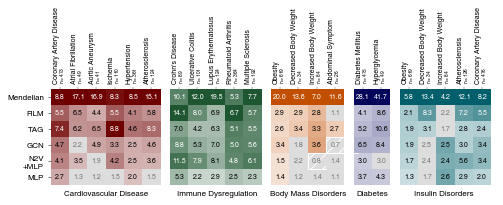

In [3]:
def plot_results(ors, disease_n, pvals = None,  need_transpose = True, pval_cutoff=0.05, adjust = False, drop_union=False):
    """ ors and pvals are dicts which contain one df per disease. dfs have n_methods rows and n_disease_subtypes columns """
    import numpy as np
    from statsmodels.stats.multitest import fdrcorrection as fdr
    border_size = 0.01
    regular_height = 1
    break_height = 0.5
    break_width = 0.5
    regular_width = 1 - border_size
    value_font_size = medium_font-1
    label_font_size = medium_font
    
    crimson = "#6f0000"
    navy = "#02055a"
    jungle = "#1e5631"
    tan = "#c24e00"
    petrol = "#005f6a"
    purple = "#3c1361"
    grey = "#bbbbbb"

    color_gradients = []
    for colors in [crimson, jungle, tan, navy, petrol]:
        color_gradients.append({x: colorFader(c1 = colors, mix = ((100-x)/100) * 0.85 ) for x in range(101)})

    grey_gradient = {x: colorFader(c1 = grey, mix = ((100-x)/100) * 0.85 ) for x in range(101)}

    outer_labels = list(ors.keys())
    diseases = []
    one_large_df = None
    dfs = []
    main_diseases = []

    for i, (disease, df) in enumerate(ors.items()):
        if need_transpose:
            df = df.transpose()
        if drop_union:
            df = df.drop("Union", axis=1)
        for subtype in df.columns:
            main_diseases.append((i, disease))
        diseases.extend(list(df.columns) + ["break"])
        methods = df.index.tolist()[::-1]
        dfs.append(df)

    pval_dfs = []
    for i, (disease, df) in enumerate(pvals.items()):
        if need_transpose:
            df = df.transpose()
        if drop_union:
            df = df.drop("Union", axis=1)
        pval_dfs.append(df)

    one_large_df = pd.concat(dfs, axis=1)
    pval_df = pd.concat(pval_dfs, axis=1)
    # remove last break
    diseases = diseases[:-1]
    disease_n = [value for values in disease_n.values() for value in values.tolist() + ["break"]]
    fig, ax = plt.subplots(figsize=(full_width*cm, ((1*len(methods))+1.5)*cm))
    
    diseases_without_breaks = [label for label in diseases if label != "break"]

    values = one_large_df.values
    pvals = pval_df.values
    if adjust:
        pvals_shape = pvals.shape
        pvals = fdr(pvals.flatten())[1].reshape(pvals_shape)
    
    all_main_diseases = main_diseases[:]
    for i, index in enumerate(methods):
        main_diseases = all_main_diseases[:]
        running_index = 0
        for c, column in enumerate(diseases):
                
            
            height = break_height if index == "break" else regular_height
            width = break_width if column == "break" else regular_width

                
            if "break" in [index, column]:
                color = "w"
            else:
                main_disease = main_diseases[0]
                main_diseases.remove(main_disease)
                """
                    try:
                    if drop_union:
                        n_dge = disease_n[main_disease[1]][:-1]
                    else: 
                        n_dge = disease_n[main_disease[1]]
                    disease_dge.extend(n_dge)

                    del disease_n[main_disease[1]]
                except KeyError:
                    pass
                """
                value_disease_index = running_index
                minmax_means = (values[:, value_disease_index] - 1) / (np.max(values[:, value_disease_index]) - 1)
                if pvals[methods[::-1].index(index), value_disease_index] > pval_cutoff:
                    #colors = grey_gradient
                    color = "#dddddd"
                    significant = False
                else:
                    colors = color_gradients[main_disease[0]]
                    color = colors[abs(int(100 * minmax_means[methods[::-1].index(index)]))]
                    significant = True

            kwargs = {}
            
            if values[methods[::-1].index(index), value_disease_index] < 1:
                    kwargs.update({"edgecolor": 'white', "hatch": "//"})

            bottom = np.sum([break_height if _method == "break" else regular_height for _method in methods[:i]])

            x_position = np.sum([break_width if _disease == "break" else regular_width for _disease in diseases[:c]])

            ax.bar(x_position, height=height - border_size, bottom=bottom,
                                color=color, width=width, **kwargs)
                
            
            if not "break" in [index, column]:
                if significant:
                    color = "w" if minmax_means[methods[::-1].index(index)] > 0.5 else "black"
                else: 
                    color = "#777777"
                text = str(round(values[methods[::-1].index(index), value_disease_index], 1))
                            
                ax.text(x_position, bottom + (0.5*height), text, ha='center',va='center',
                                    size=value_font_size, color=color)
                #weight='bold'
            if column != "break":
                running_index += 1

    yticks = []
    for index in range(len(methods)):
        yticks.append(np.sum([break_height if label == "break" else regular_height for label in methods[:index + 1]]) - 0.5)

    xticks = []
    for index in range(len(diseases)):
        xticks.append(np.sum([break_width if label == "break" else regular_width for label in diseases[:index + 1]]) - 1)

    
    ax.set_yticks(np.asarray(yticks)[np.asarray([label != "break" for label in methods], dtype = np.bool8)])
    ax.set_yticklabels([label for label in methods if label != "break"], size=label_font_size)
    ax2 = ax.twiny()
    print(disease_n)
    ax.set_xticks(np.asarray(xticks)[np.asarray([label != "break" for label in diseases], dtype = np.bool8)])
    ax.set_xticklabels([label + "\n$\\regular_{n=%s}$" % number for label, number in zip(diseases, disease_n) if label != "break"], rotation=90, size=label_font_size-1, ma="left", linespacing=0.5)


    ax2.set_xticks([2.5, 8.5, 13.4, 16.85, 20.7])
    ax2.set_xticklabels(outer_labels, size=label_font_size)

    ax.xaxis.set_ticks_position('top')
    ax2.xaxis.set_ticks_position('bottom')

    for axe in [ax, ax2]:
        axe.spines['top'].set_visible(False)
        axe.spines['right'].set_visible(False)
        axe.spines['bottom'].set_visible(False)
        axe.spines['left'].set_visible(False)
    ax.set_ylim((0, np.sum([break_height if _method == "break" else regular_height for _method in methods]) - border_size))
    ax.set_xlim((- width/2, len(diseases) - ((width/2) ) - 2*width))
    ax2.set_xlim((- width/2, len(diseases) - ((width/2) ) - 2*width))
    
    plt.tick_params(bottom = False)
    plt.tight_layout()
    return fig, ax

plot_results(disease_ors, disease_n_dge, disease_pvals)

plt.savefig("dge_new_cs{}.svg".format(convergence_score), transparent=False)

# Now with FiLM-Unbiased

In [4]:
from speos.utils.config import Config
from speos.postprocessing.postprocessor import PostProcessor

import json
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection as fdr

convergence_score = 1

diseases = ["cardiovascular", "immune_dysregulation", "bm_disorder", "diabetes", "insulin_disorder"]
pretty_diseases = ["Cardiovascular Disease", "Immune Dysregulation", "Body Mass Disorders", "Diabetes", "Insulin Disorders"]
methods = ["film", "film_unbiased", "tag", "gcn", "n2vmlp", "mlp"]
pretty_methods = ["FiLM", "FiLM-Unbiased", "TAG", "GCN", "N2V\n+MLP", "MLP"]

disease_ors = {disease: None for disease in pretty_diseases}
disease_pvals = {disease: None for disease in pretty_diseases}
disease_n_dge = {disease: None for disease in pretty_diseases}

outer_dfs_list = []

for disease, pretty_disease in zip(diseases, pretty_diseases):
    all_results = []
    for method, pretty_method in zip(methods, pretty_methods):
        if disease == "immune_dysregulation" and method == "film":
            method = "film_forreal"
        if method in ["gcn", "mlp", "n2vmlp"] and disease == "immune_dysregulation":
            method += "_new"

        config = Config()
        config.parse_yaml("/home/icb/florin.ratajczak/ppi-core-genes/configs/config_{}_{}.yaml".format(disease, method))
        
        pp = PostProcessor(config)

        outer_results = "/lustre/groups/epigenereg01/projects/ppi-florin/results/{}_{}outer_results.json".format(disease, method)
        results_file = "/lustre/groups/epigenereg01/projects/ppi-florin/results/{}_{}_outer_0_fold_1.tsv".format(disease, method)

        with open(outer_results, "r") as file:
            outer_results = json.load(file)

        pp.outer_result = outer_results
        pp.init_pp_table()
        results = pp.dge(results_file, convergence_score = convergence_score)

        results = results.drop("Union", axis=0)
        
        if disease_ors[pretty_disease] is None:
            disease_ors[pretty_disease] = pd.DataFrame(data=results["Mendelian ORs"].values, index=results.index, columns=["Mendelian\n(Ground Truth)"])
            disease_pvals[pretty_disease] = pd.DataFrame(data=results["Mendelian pvals"].values, index=results.index, columns=["Mendelian\n(Ground Truth)"])
        disease_ors[pretty_disease][pretty_method] = results["Candidate ORs"].values
        disease_pvals[pretty_disease][pretty_method] = np.zeros_like(results["Candidate pvals"].values)
        disease_n_dge[pretty_disease] = results["N DEG"].values

        all_results.append(results)
    
    all_results = pd.concat(all_results, keys=["".join(method.split("\n")) for method in pretty_methods])
    for column in all_results.columns:
        if "OR" in column:
            all_results[column] = all_results[column].round(3)
        if column.startswith("N ") :
            all_results[column] = all_results[column].astype(int)
    outer_dfs_list.append(all_results)

pvals = []
n_candidate = 0
lengths = []
for df in outer_dfs_list:
    new_pvals = df["Candidate pvals"].tolist()
    pvals.extend(new_pvals)
    n_candidate += len(new_pvals)
    lengths.append(len(new_pvals))

print(lengths)

n_mendelian = 0
for df in outer_dfs_list:
    new_pvals = df["Mendelian pvals"].tolist()
    pvals.extend(new_pvals)
    n_mendelian += len(new_pvals)
    
adj_pvals = fdr(pvals)[1]
candidate_pvals = adj_pvals[:n_candidate]
mendelian_pvals = adj_pvals[n_candidate:]
assert len(mendelian_pvals) == n_mendelian
previous_length = 0

for i, (df, disease) in enumerate(zip(outer_dfs_list, pretty_diseases)):
    if i > 0:
        candidates = candidate_pvals[previous_length:lengths[i]+previous_length]
        mendelians = mendelian_pvals[previous_length:lengths[i]+previous_length]
    else:
        candidates = candidate_pvals[:lengths[i]]
        mendelians = mendelian_pvals[:lengths[i]]
    previous_length += lengths[i]

    print((candidates < 0.05).sum())
    df["Candidate adjusted pvals (FDR)"] = candidates
    print((df["Candidate adjusted pvals (FDR)"] < 0.05).sum())
    df["Mendelian adjusted pvals (FDR)"] = mendelians
    columns = df.columns
    df = df[columns[4:-2].tolist() + columns[:4].tolist() + columns[-2:].tolist()]
    df.to_csv("statistical_dump/{}_ors_dge_cs{}_unbiased.tsv".format(disease, convergence_score), sep="\t")

for df, pretty_disease in zip(outer_dfs_list, pretty_diseases):
    for pretty_method in pretty_methods:
        subset_df = df.loc["".join(pretty_method.split("\n"))]
        disease_pvals[pretty_disease]["Mendelian"] = subset_df["Mendelian adjusted pvals (FDR)"].tolist()
        disease_pvals[pretty_disease][pretty_method] = subset_df["Candidate adjusted pvals (FDR)"].tolist()

print(disease_pvals["Cardiovascular Disease"].transpose())
print(disease_ors["Cardiovascular Disease"].transpose())

cardiovascular_film 2023-01-27 12:11:35,631 [INFO] speos.postprocessing.postprocessor: Starting Differential Gene Expression Enrichment Analysis.
cardiovascular_film 2023-01-27 12:11:35,636 [INFO] speos.postprocessing.postprocessor: Found 5 subtypes for phenotype insulin_disorder: ['Obesity', 'Decreased Body Weight', 'Increased Body Weight', 'Atherosclerosis', 'Coronary Artery Disease'].
cardiovascular_film 2023-01-27 12:11:35,713 [INFO] speos.postprocessing.postprocessor: Total of 651 Obesity DE genes, 619 of them match with our translation table.
cardiovascular_film 2023-01-27 12:11:35,714 [INFO] speos.postprocessing.postprocessor: Found 96 Obesity DE genes among the 610 known positive genes (p: 5.41e-36, OR: 5.81), leaving 523 in 16791 Unknowns
cardiovascular_film 2023-01-27 12:11:35,727 [INFO] speos.postprocessing.postprocessor: Fishers Exact Test for Obesity DE genes among Predicted Genes. p: 3.87e-03, OR: 1.338
cardiovascular_film 2023-01-27 12:11:35,727 [INFO] speos.postprocessi

[36, 30, 24, 12, 30]
28
28
30
30
13
13
11
11
24
24
                           Coronary Artery Disease  Atrial Fibrillation  \
Mendelian\n(Ground Truth)             7.961798e-50         1.070563e-14   
FiLM                                  2.223958e-18         2.337723e-03   
FiLM-Unbiased                         6.347986e-20         2.801621e-01   
TAG                                   2.347419e-44         2.302052e-04   
GCN                                   2.082348e-20         1.878686e-01   
N2V\n+MLP                             6.168878e-15         4.131083e-02   
MLP                                   5.784040e-15         6.112186e-01   
Mendelian                             1.751596e-48         2.395159e-14   

                           Aortic Aneurysm      Ischemia  Hypertension  \
Mendelian\n(Ground Truth)     1.954172e-12  2.052073e-13  4.227765e-38   
FiLM                          4.292816e-02  1.014508e-05  2.047286e-09   
FiLM-Unbiased                 5.588580e-02  6.08257

[473, 49, 41, 110, 361, 124, 'break', 89, 101, 124, 364, 192, 'break', 619, 34, 84, 26, 'break', 475, 49, 'break', 619, 34, 84, 126, 476, 'break']


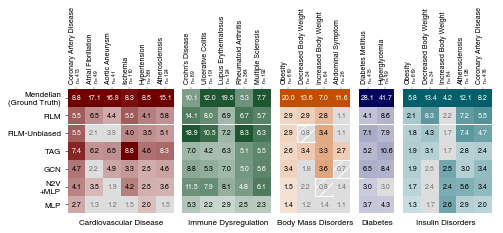

In [5]:
plot_results(disease_ors,disease_n_dge, disease_pvals)

plt.savefig("dge_new_unbiased_cs{}.svg".format(convergence_score), transparent=False)